In [ ]:
from google.colab import drive
# drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


frames_dir = r'/content/drive/MyDrive/Monular3D/frames'


masks_dir = r'/content/drive/MyDrive/Monular3D/lane-masks'    

Number of frames: 3626
Number of masks: 3626
Frame - Shape: (720, 1280, 3), Data type: uint8
Mask - Shape: (720, 1280), Data type: uint8


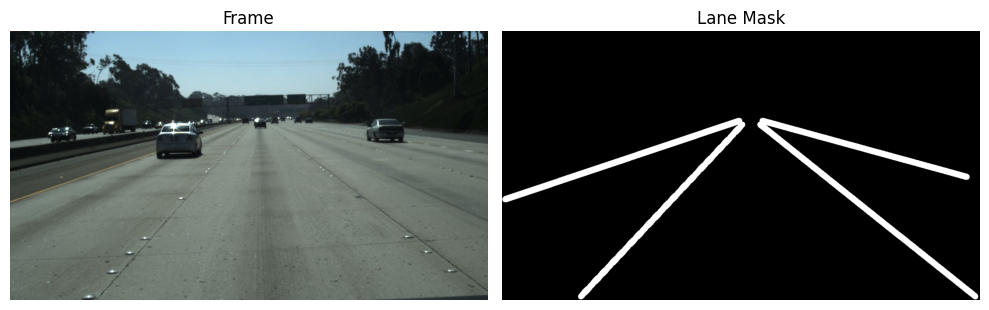

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define paths to your dataset
frames_path =  r'/content/drive/MyDrive/Monular3D/frames'  # Update with the path to your frame images
masks_path = r'/content/drive/MyDrive/Monular3D/lane-masks'    # Update with the path to your lane mask images

# Function to get basic information about the dataset
def inspect_data(frames_path, masks_path):
    # Get list of files
    frame_files = sorted(os.listdir(frames_path))
    mask_files = sorted(os.listdir(masks_path))

    # Check total number of files
    print(f"Number of frames: {len(frame_files)}")
    print(f"Number of masks: {len(mask_files)}")

    # Check if the number of frames matches the number of masks
    if len(frame_files) != len(mask_files):
        print("Warning: The number of frames and masks do not match!")

    # Inspect the first frame and mask
    if frame_files and mask_files:
        frame = cv2.imread(os.path.join(frames_path, frame_files[0]))
        mask = cv2.imread(os.path.join(masks_path, mask_files[0]), cv2.IMREAD_GRAYSCALE)

        # Print dimensions and datatype
        print(f"Frame - Shape: {frame.shape}, Data type: {frame.dtype}")
        print(f"Mask - Shape: {mask.shape}, Data type: {mask.dtype}")

        # Display frame and mask
        display_frame_and_mask(frame, mask)
    else:
        print("No files found in one or both folders.")

# Function to display frame and mask side by side
def display_frame_and_mask(frame, mask):
    plt.figure(figsize=(10, 5))

    # Display the frame
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title("Frame")
    plt.axis("off")

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Lane Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to inspect the dataset
inspect_data(frames_path, masks_path)


#LaneATT

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F

# Paths to dataset
FRAMES_DIR = r'/content/drive/MyDrive/Monular3D/frames'
MASKS_DIR =  r'/content/drive/MyDrive/Monular3D/lane-masks'

# Define Dataset Class
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None):
        self.frames = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir)])
        self.masks = sorted([os.path.join(masks_dir, m) for m in os.listdir(masks_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        # Load image and mask
        frame = cv2.imread(self.frames[idx])
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Ensure mask values are 0 or 1 (binary mask)
        mask = (mask > 127).astype(np.float32)  # Binarize the mask (assuming 0–255 range)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=frame, mask=mask)
            frame = augmented['image']
            mask = augmented['mask']

        return frame, mask

# Define transformations
transform = A.Compose([
    A.Resize(360, 640),  # Resize to reduce memory usage
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
    ToTensorV2()
])

# Create Dataset and DataLoaders
dataset = LaneDataset(FRAMES_DIR, MASKS_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Define a lightweight model for lane detection
class LaneATT(nn.Module):
    def __init__(self):
        super(LaneATT, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.classifier = nn.Conv2d(128, 1, kernel_size=1)  # Output binary lane mask

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        logits = F.interpolate(logits, scale_factor=4, mode="bilinear", align_corners=False)  # Upsample
        return logits

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneATT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for frames, masks in train_loader:
            frames, masks = frames.to(device), masks.to(device).unsqueeze(1)  # Add channel dim for masks

            # Forward pass
            outputs = model(frames)
            loss = criterion(outputs, masks.float())  # Ensure masks are float32 for loss calculation

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for frames, masks in val_loader:
                frames, masks = frames.to(device), masks.to(device).unsqueeze(1)

                outputs = model(frames)
                loss = criterion(outputs, masks.float())
                val_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}")

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch [1/10], Train Loss: 0.3683, Val Loss: 0.2298
Epoch [2/10], Train Loss: 0.1877, Val Loss: 0.1672
Epoch [3/10], Train Loss: 0.1542, Val Loss: 0.1510
Epoch [4/10], Train Loss: 0.1438, Val Loss: 0.1421
Epoch [5/10], Train Loss: 0.1394, Val Loss: 0.1400
Epoch [6/10], Train Loss: 0.1367, Val Loss: 0.1361
Epoch [7/10], Train Loss: 0.1348, Val Loss: 0.1376
Epoch [8/10], Train Loss: 0.1332, Val Loss: 0.1331
Epoch [9/10], Train Loss: 0.1316, Val Loss: 0.1351
Epoch [10/10], Train Loss: 0.1305, Val Loss: 0.1310


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to calculate Intersection over Union (IoU)
def iou_score(pred, target):
    # Flatten the predictions and ground truth
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate intersection and union
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = intersection / (union + 1e-6)  # Add epsilon to avoid division by zero

    return iou.item()

# Function to calculate Dice Coefficient
def dice_score(pred, target):
    # Flatten the predictions and ground truth
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = torch.sum(pred * target)
    dice = (2. * intersection + 1e-6) / (torch.sum(pred) + torch.sum(target) + 1e-6)

    return dice.item()

# Function to calculate pixel accuracy
def pixel_accuracy(pred, target):
    # Flatten the predictions and ground truth
    pred = pred.view(-1)
    target = target.view(-1)

    # Calculate the accuracy
    correct = torch.sum(pred == target)
    total = target.numel()

    return correct.float() / total

# Function to evaluate the model
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_iou = 0
    total_dice = 0
    total_accuracy = 0
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for frames, masks in val_loader:
            frames, masks = frames.to(device), masks.to(device).unsqueeze(1)  # Add channel dim

            # Forward pass
            outputs = model(frames)
            loss = criterion(outputs, masks.float())
            total_loss += loss.item()

            # Get predictions (threshold logits to get binary mask)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probability values
            preds = preds > 0.5  # Convert to binary mask (threshold at 0.5)

            # Calculate metrics
            total_iou += iou_score(preds, masks)
            total_dice += dice_score(preds, masks)
            total_accuracy += pixel_accuracy(preds, masks)

            total_samples += 1

    # Calculate average metrics over all samples
    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples
    avg_accuracy = total_accuracy / total_samples
    avg_loss = total_loss / total_samples

    print(f"Evaluation Results: \n"
          f"Avg Loss: {avg_loss:.4f}, "
          f"Avg IoU: {avg_iou:.4f}, "
          f"Avg Dice Coefficient: {avg_dice:.4f}, "
          f"Avg Pixel Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_iou, avg_dice, avg_accuracy

# Example of how to use the evaluation function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, val_loader, criterion, device)


Evaluation Results: 
Avg Loss: 0.1310, Avg IoU: 0.1512, Avg Dice Coefficient: 0.2611, Avg Pixel Accuracy: 0.9615


(0.1310421313558306,
 0.1512341193117938,
 0.26107378410441534,
 tensor(0.9615, device='cuda:0'))

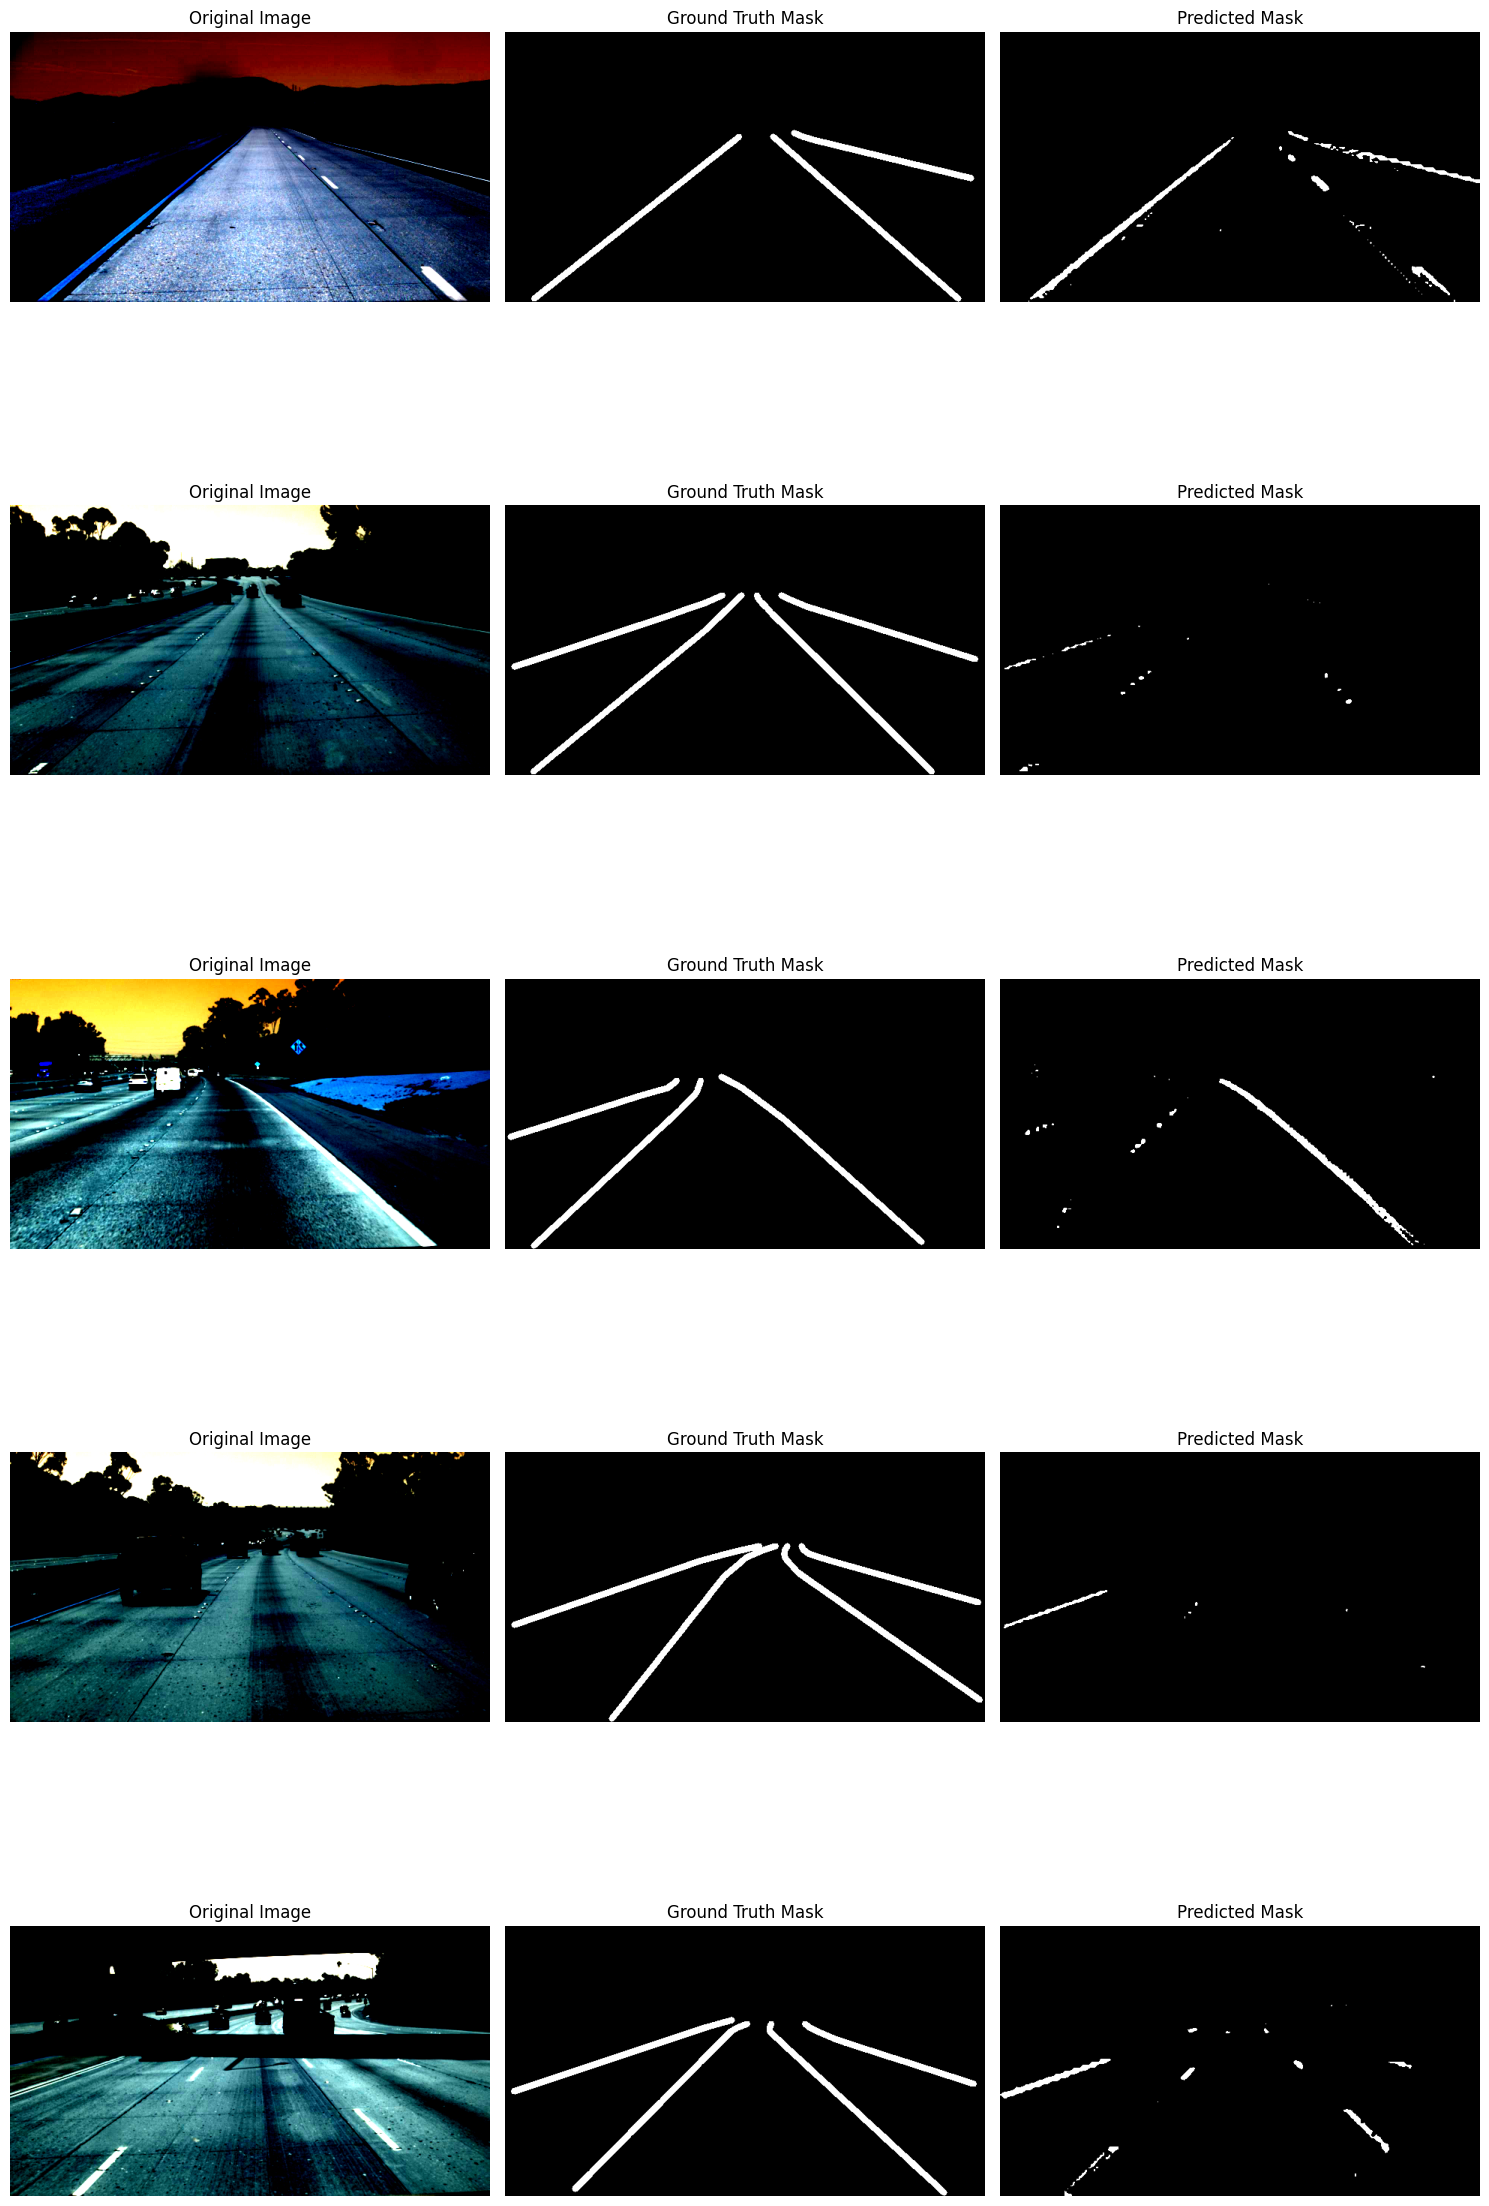

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize predictions and ground truth
def visualize_predictions(model, val_loader, device, num_samples=5):
    model.eval()  # Set model to evaluation mode

    # Set up the plotting grid (2 rows, num_samples columns)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    # Loop through some samples in the validation set
    with torch.no_grad():
        for i, (frames, masks) in enumerate(val_loader):
            if i >= num_samples:
                break

            frames, masks = frames.to(device), masks.to(device).unsqueeze(1)  # Add channel dim to mask
            outputs = model(frames)

            # Get predictions (threshold logits to get binary mask)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probability values
            preds = preds > 0.5  # Convert to binary mask (threshold at 0.5)

            # Convert tensors to numpy arrays for visualization
            frame = frames.cpu().numpy()[0].transpose(1, 2, 0)  # Convert to HWC format (channels last)
            mask = masks.cpu().numpy()[0]  # Ground truth mask
            pred = preds.cpu().numpy()[0]  # Predicted mask

            # Plot the original frame, ground truth mask, and predicted mask
            axes[i, 0].imshow(frame)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask[0], cmap='gray')  # Display ground truth mask
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred[0], cmap='gray')  # Display predicted mask
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(model, val_loader, device, num_samples=5)


#2D lane detection using U-Net

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, mean_absolute_error
from torch.optim.lr_scheduler import StepLR

# Paths to dataset
FRAMES_DIR = r'/content/drive/MyDrive/Monular3D/frames'
MASKS_DIR =  r'/content/drive/MyDrive/Monular3D/lane-masks'

# Define Dataset Class with enhanced data augmentation
class LaneDataset(Dataset):
    def __init__(self, frames_dir, masks_dir, transform=None):
        self.frames = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir)])
        self.masks = sorted([os.path.join(masks_dir, m) for m in os.listdir(masks_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        # Load image and mask
        frame = cv2.imread(self.frames[idx])
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Ensure mask values are 0 or 1 (binary mask)
        mask = (mask > 127).astype(np.float32)  # Binarize the mask (assuming 0–255 range)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=frame, mask=mask)
            frame = augmented['image']
            mask = augmented['mask']

        return frame, mask

# Define advanced transformations (including random crop, flip, brightness variation, etc.)
transform = A.Compose([
    A.RandomCrop(width=600, height=400),  # Random crop for variability
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.RandomBrightnessContrast(p=0.2),  # Random brightness and contrast adjustment
    A.Resize(360, 640),  # Resize to reduce memory usage
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
    ToTensorV2()
])

# Create Dataset and DataLoaders
dataset = LaneDataset(FRAMES_DIR, MASKS_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Define U-Net architecture with attention mechanisms
class UNetWithAttention(nn.Module):
    def __init__(self):
        super(UNetWithAttention, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.encoder[0:2](x)
        x2 = self.encoder[2:4](x1)
        x3 = self.encoder[4:](x2)

        middle = self.middle(x3)

        x4 = self.decoder[0:2](middle)
        x5 = self.decoder[2:](x4)

        return x5

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetWithAttention().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Learning rate scheduler
criterion = nn.BCEWithLogitsLoss()  # Use BCE loss with logits

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    # Enable automatic mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Track best model
    best_val_loss = float('inf')
    best_model_state = None

    # Training history
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0

        # Use tqdm for progress bar
        for batch_idx, (frames, masks) in enumerate(train_loader):
            # Move data to GPU and prepare masks
            frames = frames.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).unsqueeze(1)

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(frames)
                loss = criterion(outputs, masks.float())

            # Backward pass with gradient scaling
            optimizer.zero_grad(set_to_none=True)  # Slightly faster than zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} [{batch_idx}/{len(train_loader)}] '
                      f'Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for frames, masks in val_loader:
                frames = frames.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True).unsqueeze(1)

                outputs = model(frames)
                loss = criterion(outputs, masks.float())
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Update learning rate
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}]:")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

    # Restore best model
    model.load_state_dict(best_model_state)
    return model, history

# Memory management utilities
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Usage example
model = model.to(device)
model, training_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10)

<ipython-input-13-4f4ad67f1146>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-13-4f4ad67f1146>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1/10 [0/363] Loss: 0.7114
Epoch: 1/10 [100/363] Loss: 0.2394
Epoch: 1/10 [200/363] Loss: 0.2201
Epoch: 1/10 [300/363] Loss: 0.1983
Epoch [1/10]:
Train Loss: 0.2607
Val Loss: 0.2103
Learning Rate: 0.000100
--------------------------------------------------
Epoch: 2/10 [0/363] Loss: 0.1981
Epoch: 2/10 [100/363] Loss: 0.2023
Epoch: 2/10 [200/363] Loss: 0.2166
Epoch: 2/10 [300/363] Loss: 0.2073
Epoch [2/10]:
Train Loss: 0.2005
Val Loss: 0.2046
Learning Rate: 0.000100
--------------------------------------------------
Epoch: 3/10 [0/363] Loss: 0.2298
Epoch: 3/10 [100/363] Loss: 0.2288
Epoch: 3/10 [200/363] Loss: 0.1748
Epoch: 3/10 [300/363] Loss: 0.1555
Epoch [3/10]:
Train Loss: 0.1918
Val Loss: 0.1885
Learning Rate: 0.000100
--------------------------------------------------
Epoch: 4/10 [0/363] Loss: 0.1998
Epoch: 4/10 [100/363] Loss: 0.1785
Epoch: 4/10 [200/363] Loss: 0.1935
Epoch: 4/10 [300/363] Loss: 0.1815
Epoch [4/10]:
Train Loss: 0.1856
Val Loss: 0.1854
Learning Rate: 0.000100

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

class MetricTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.iou = 0
        self.dice = 0
        self.accuracy = 0
        self.loss = 0
        self.count = 0

    def update(self, iou, dice, accuracy, loss):
        self.iou += iou
        self.dice += dice
        self.accuracy += accuracy
        self.loss += loss
        self.count += 1

    def get_averages(self):
        return {
            'iou': self.iou / self.count,
            'dice': self.dice / self.count,
            'accuracy': self.accuracy / self.count,
            'loss': self.loss / self.count
        }

@torch.no_grad()
def evaluate_model(model, val_loader, criterion, device, threshold=0.5):
    """
    Evaluate the model using various metrics.
    Args:
        model: The neural network model
        val_loader: Validation data loader
        criterion: Loss function
        device: Device to run evaluation on
        threshold: Threshold for binary prediction (default: 0.5)
    Returns:
        tuple: (avg_loss, avg_iou, avg_dice, avg_accuracy)
    """
    model.eval()
    metrics = MetricTracker()

    # Enable automatic mixed precision for faster evaluation
    with torch.cuda.amp.autocast():
        # Use tqdm for progress tracking
        for frames, masks in tqdm(val_loader, desc="Evaluating"):
            # Move data to device efficiently
            frames = frames.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).unsqueeze(1)

            # Forward pass
            outputs = model(frames)
            loss = criterion(outputs, masks.float())

            # Get predictions
            with torch.no_grad():
                preds = torch.sigmoid(outputs)
                preds = (preds > threshold).float()

            # Calculate metrics (batch-wise)
            batch_iou = iou_score(preds, masks)
            batch_dice = dice_score(preds, masks)
            batch_accuracy = pixel_accuracy(preds, masks)

            # Update metrics
            metrics.update(
                iou=batch_iou.item(),
                dice=batch_dice.item(),
                accuracy=batch_accuracy.item(),
                loss=loss.item()
            )

    # Get average metrics
    avg_metrics = metrics.get_averages()

    # Clear GPU memory
    clear_gpu_memory()

    # Print detailed results
    print("\nEvaluation Results:")
    print(f"{'Metric':15} {'Value':10}")
    print("-" * 25)
    print(f"{'Loss':15} {avg_metrics['loss']:.4f}")
    print(f"{'IoU':15} {avg_metrics['iou']:.4f}")
    print(f"{'Dice Score':15} {avg_metrics['dice']:.4f}")
    print(f"{'Accuracy':15} {avg_metrics['accuracy']:.4f}")

    return (
        avg_metrics['loss'],
        avg_metrics['iou'],
        avg_metrics['dice'],
        avg_metrics['accuracy']
    )

# Helper functions for metric calculations
def iou_score(pred, target):
    """Calculate IoU score between prediction and target masks."""
    intersection = torch.logical_and(pred, target).sum((1, 2, 3))
    union = torch.logical_or(pred, target).sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def dice_score(pred, target):
    """Calculate Dice score between prediction and target masks."""
    intersection = torch.logical_and(pred, target).sum((1, 2, 3))
    total = pred.sum((1, 2, 3)) + target.sum((1, 2, 3))
    dice = (2.0 * intersection + 1e-6) / (total + 1e-6)
    return dice.mean()

def pixel_accuracy(pred, target):
    """Calculate pixel-wise accuracy between prediction and target masks."""
    correct = (pred == target).float().sum((1, 2, 3))
    total = torch.ones_like(pred).sum((1, 2, 3))
    return (correct / total).mean()

def clear_gpu_memory():
    """Clear GPU memory cache."""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        import gc
        gc.collect()

# Usage example
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss, iou, dice, accuracy = evaluate_model(model, val_loader, criterion, device)

<ipython-input-14-dd8bc95e90d3>:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 91/91 [00:21<00:00,  4.14it/s]



Evaluation Results:
Metric          Value     
-------------------------
Loss            0.1760
IoU             0.2832
Dice Score      0.4232
Accuracy        0.9427


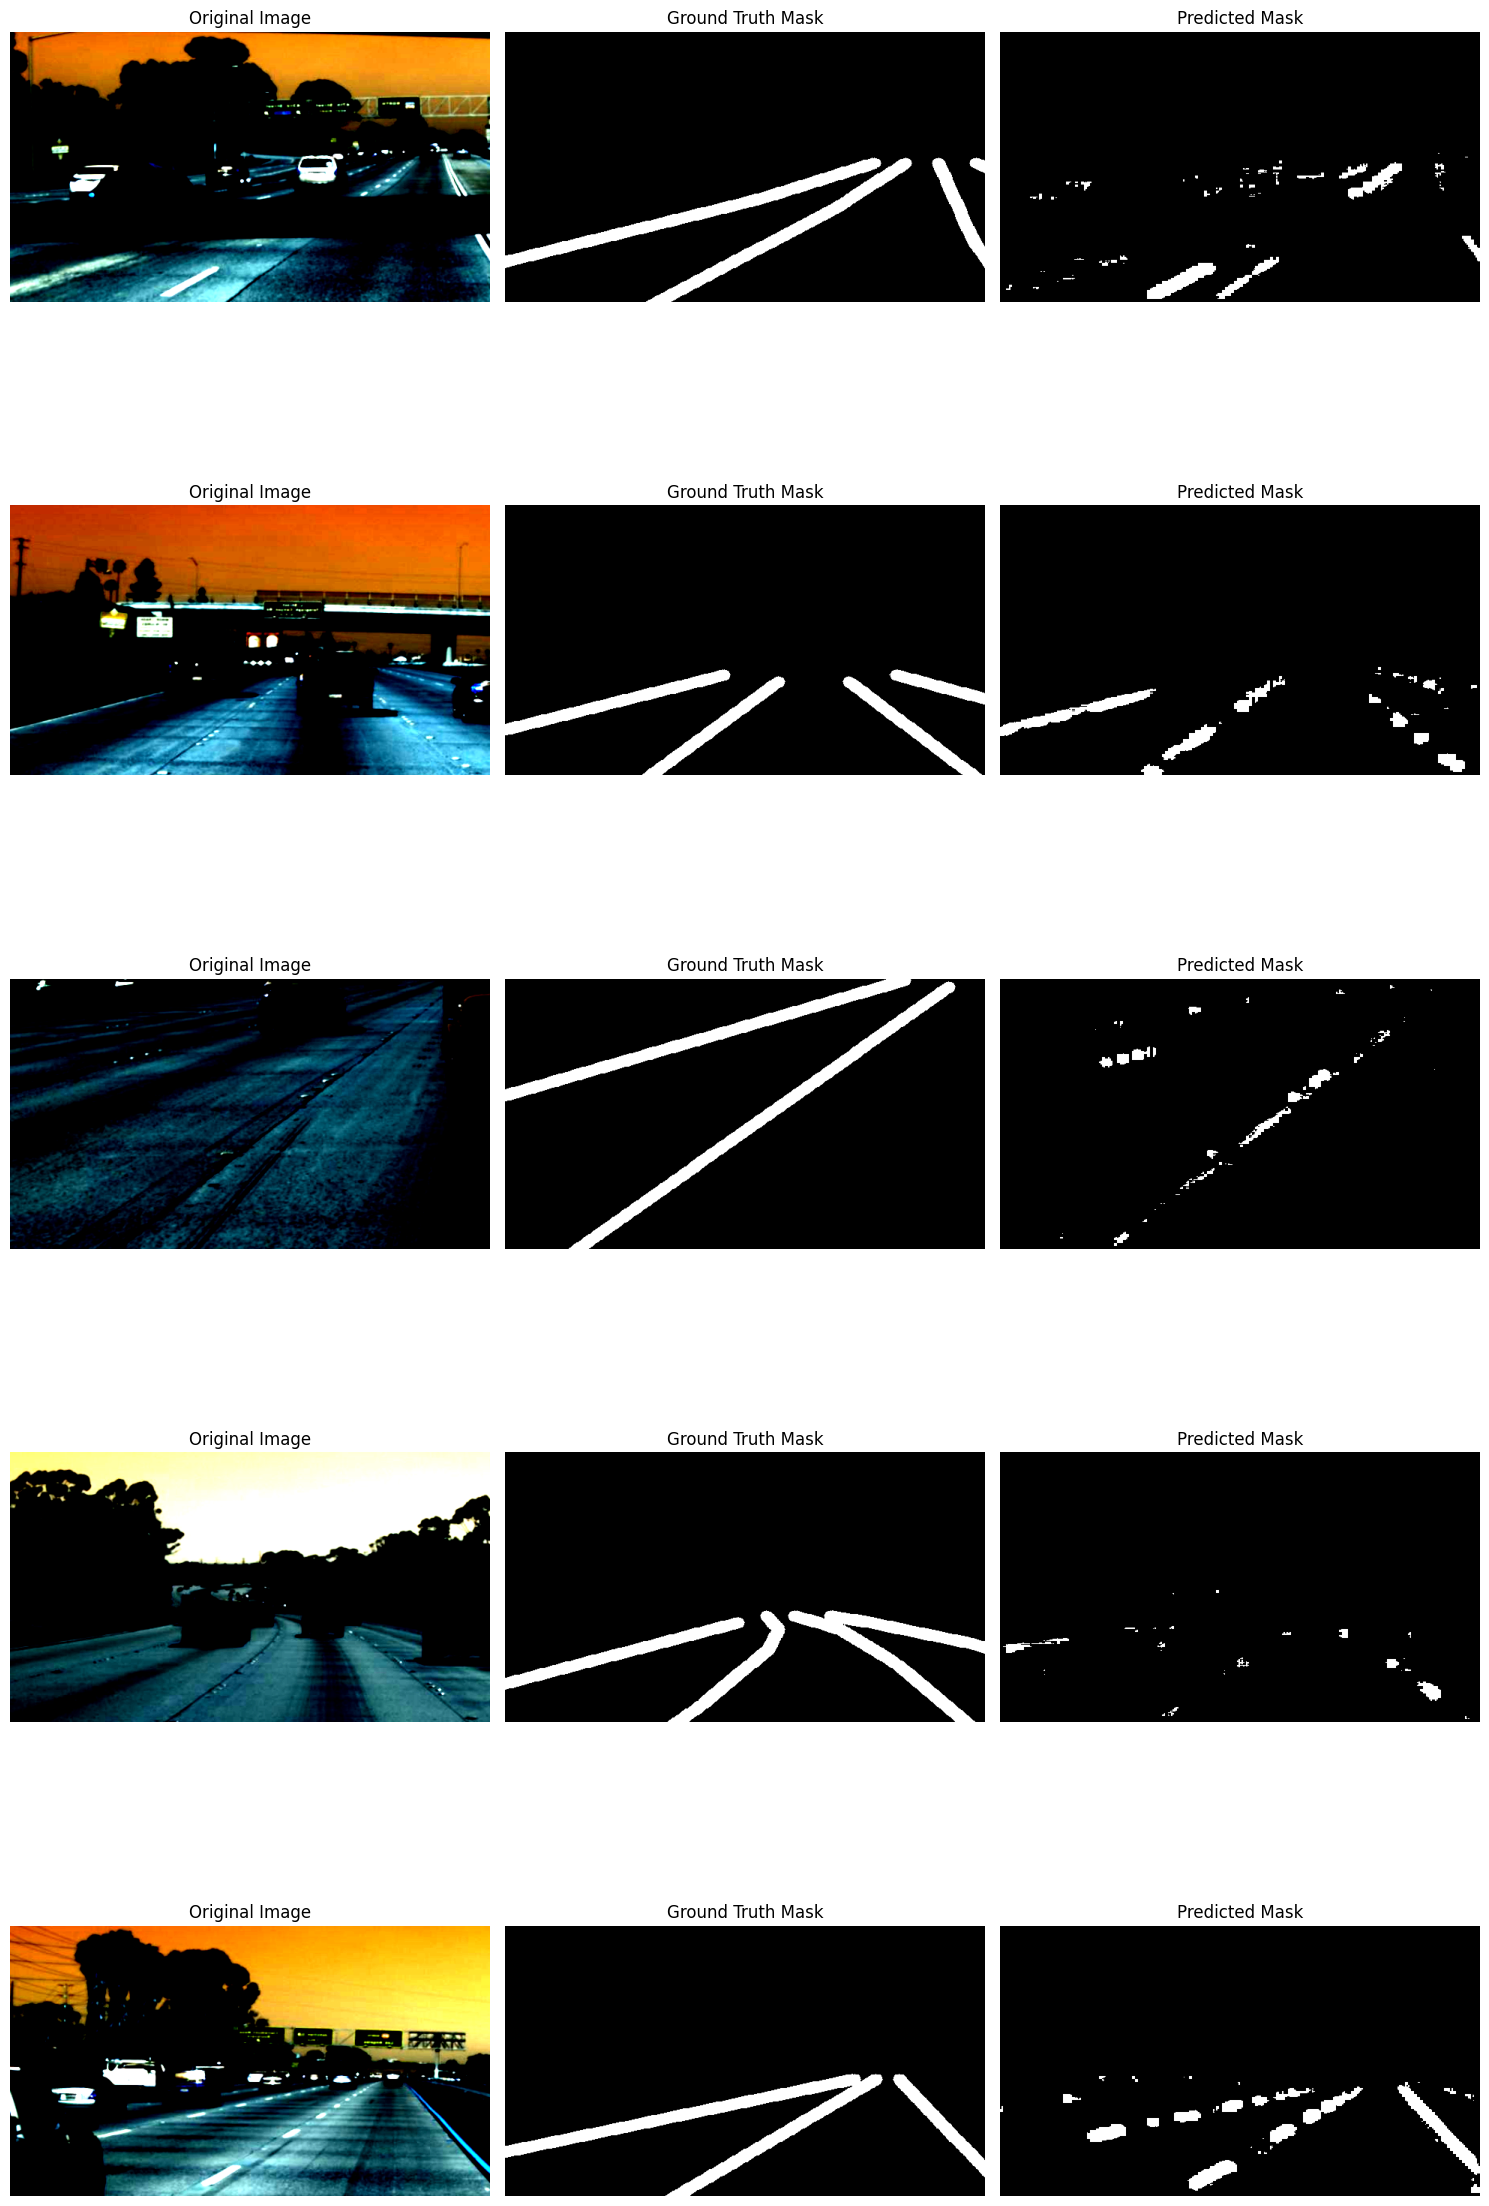

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize predictions and ground truth
def visualize_predictions(model, val_loader, device, num_samples=5):
    model.eval()  # Set model to evaluation mode

    # Set up the plotting grid (2 rows, num_samples columns)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    # Loop through some samples in the validation set
    with torch.no_grad():
        for i, (frames, masks) in enumerate(val_loader):
            if i >= num_samples:
                break

            frames, masks = frames.to(device), masks.to(device).unsqueeze(1)  # Add channel dim to mask
            outputs = model(frames)

            # Get predictions (threshold logits to get binary mask)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probability values
            preds = preds > 0.5  # Convert to binary mask (threshold at 0.5)

            # Convert tensors to numpy arrays for visualization
            frame = frames.cpu().numpy()[0].transpose(1, 2, 0)  # Convert to HWC format (channels last)
            mask = masks.cpu().numpy()[0]  # Ground truth mask
            pred = preds.cpu().numpy()[0]  # Predicted mask

            # Plot the original frame, ground truth mask, and predicted mask
            axes[i, 0].imshow(frame)
            axes[i, 0].set_title("Original Image")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask[0], cmap='gray')  # Display ground truth mask
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred[0], cmap='gray')  # Display predicted mask
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_predictions(model, val_loader, device, num_samples=5)


In [ ]:
import torch

# Assuming 'model' is your PyTorch 2D lane detection model

# 1. Save only the model's weights
def save_model_weights(model, path=r"/content/drive/MyDrive/Monular3D/lane_detection_weights.pth"):
    """
    Save only the model's weights (state dictionary).
    """
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")

# 2. Save the entire model (architecture + weights)
def save_entire_model(model, path=r"/content/drive/MyDrive/Monular3D/lane_detection_model.pth"):
    """
    Save the entire model (architecture and weights).
    """
    torch.save(model, path)
    print(f"Entire model saved to {path}")

# Example usage
# Assuming you have a trained model
model_path_weights = "lane_detection_weights.pth"
model_path_entire = "lane_detection_model.pth"

# Save model weights
save_model_weights(model, model_path_weights)

# Save the entire model
save_entire_model(model, model_path_entire)


Model weights saved to lane_detection_weights.pth
Entire model saved to lane_detection_model.pth


#Post-processing

In [ ]:
import cv2
import numpy as np
import torch
from sklearn.preprocessing import PolynomialFeatures

def preprocess_predictions(pred_mask, min_area=1000, poly_degree=2):
    """
    Preprocess the predicted lane mask to refine and map lane points.

    Parameters:
        pred_mask (np.array): The predicted binary mask for lanes.
        min_area (int): Minimum area of connected components to consider.
        poly_degree (int): Degree of the polynomial for curve fitting.

    Returns:
        lane_points (list): A list containing lane points for each lane.
    """
    # Ensure pred_mask is 2D (grayscale) by selecting the first channel if necessary
    if len(pred_mask.shape) > 2:
        pred_mask = pred_mask[:, :, 0]  # Take the first channel if it's 3D (height, width, channel)

    # Step 1: Morphological Operations (Dilation and Erosion)
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(pred_mask, kernel, iterations=2)  # Close small gaps in the lane lines
    eroded = cv2.erode(dilated, kernel, iterations=2)  # Remove small noise

    # Step 2: Connected Component Analysis to remove noise
    # Find contours in the mask to identify connected components
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    lane_points = []

    for contour in contours:
        if cv2.contourArea(contour) > min_area:  # Filter small contours (noise)
            # Step 3: Fit a polynomial to the lane points
            contour_points = contour.reshape(-1, 2)  # Flatten contour to a list of points
            x_points, y_points = contour_points[:, 0], contour_points[:, 1]

            # Use polynomial fitting to smooth the lane curve
            poly = PolynomialFeatures(degree=poly_degree)
            x_poly = poly.fit_transform(x_points.reshape(-1, 1))  # Transform x points to polynomial features

            # Fit a linear regression model (polynomial regression)
            coeffs = np.linalg.lstsq(x_poly, y_points, rcond=None)[0]

            # Generate fitted y points from the polynomial coefficients
            y_fitted = np.polyval(coeffs[::-1], x_points)

            lane_points.append(list(zip(x_points, y_fitted)))  # Store lane points

    return lane_points


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model weights (with 'weights_only=True' for safety)
model = torch.load(r'/content/drive/MyDrive/Monular3D/lane_detection_model.pth', map_location=device).to(device)
model.eval()

# Assuming val_loader is available for validation data
with torch.no_grad():
    for frames, masks in val_loader:
        frames = frames.to(device)
        outputs = model(frames)

        # Apply sigmoid and threshold to get binary mask
        preds = torch.sigmoid(outputs) > 0.5

        # Process the first prediction in the batch
        pred_mask = preds[0].cpu().numpy().astype(np.uint8)  # Convert to 2D binary mask
        lane_points = preprocess_predictions(pred_mask)



<ipython-input-17-3c0a0f35e638>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r'/content/drive/MyDrive/Monular3D/lane_detection_model.pth', map_locati

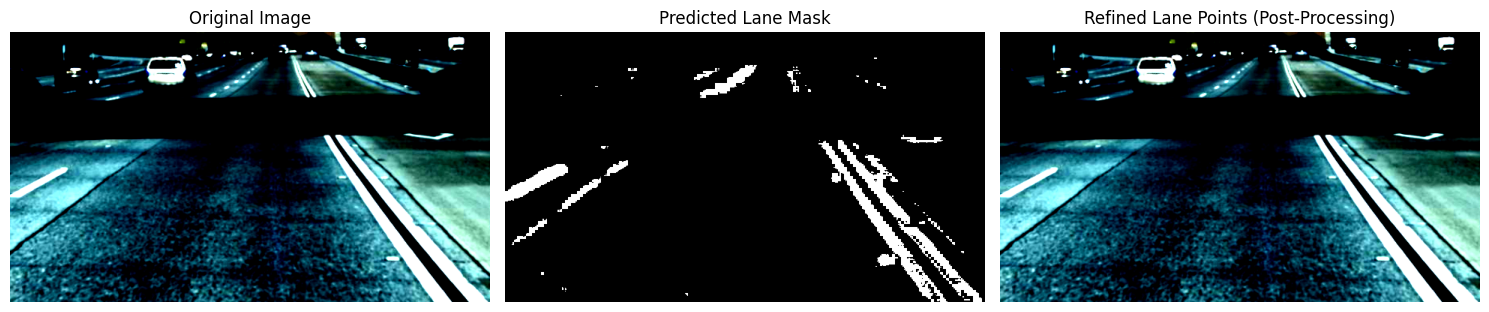

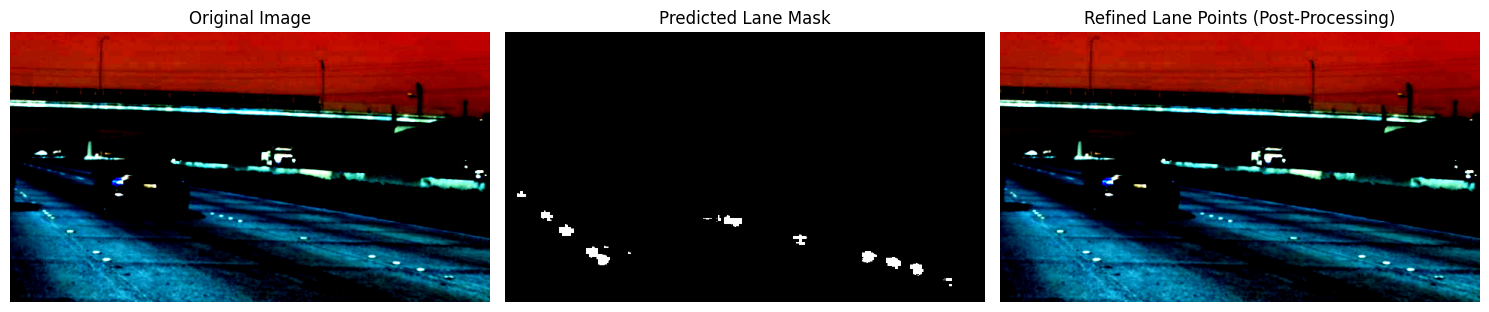

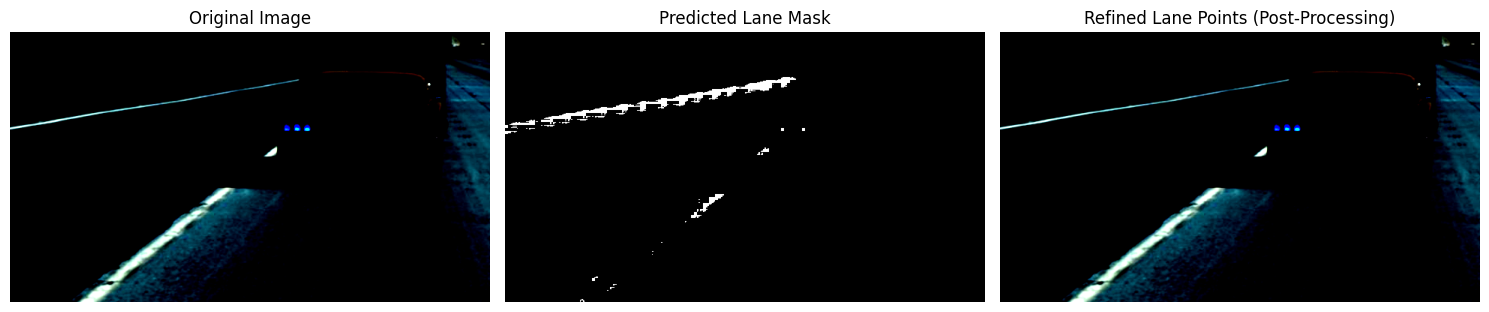

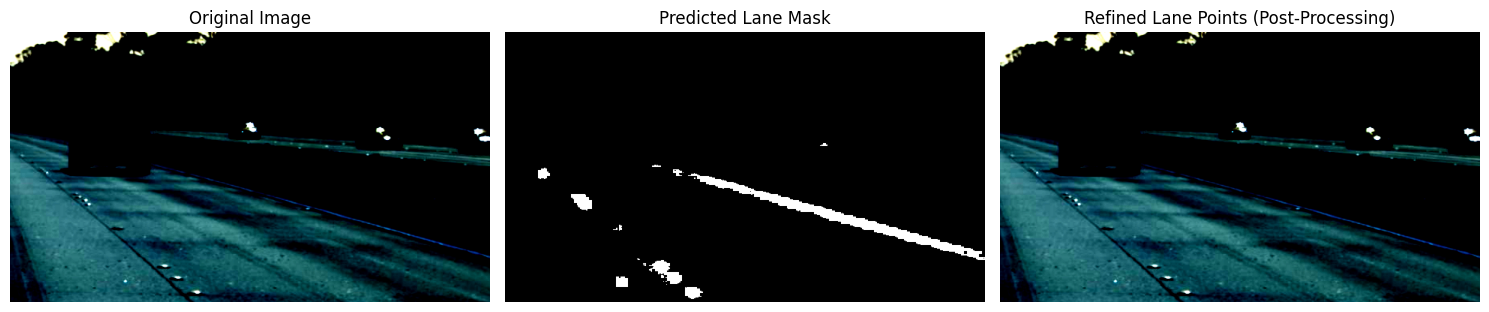

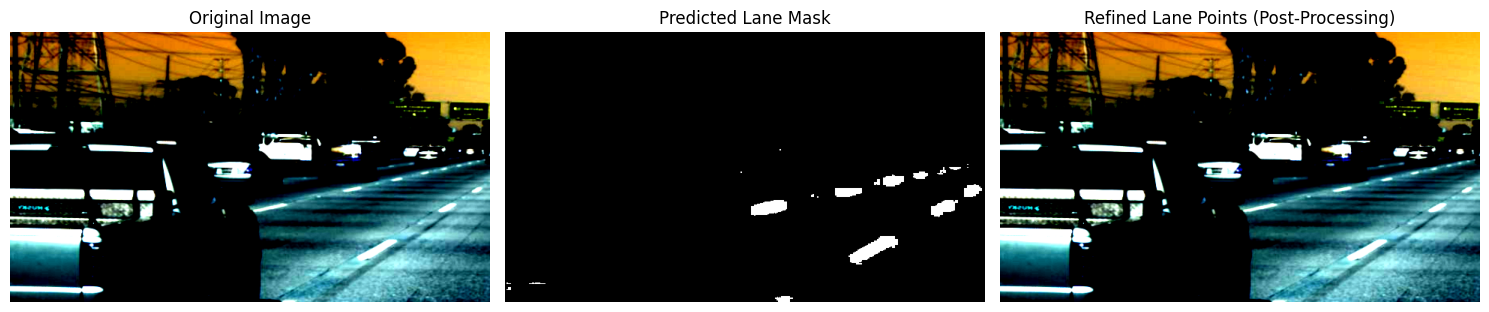

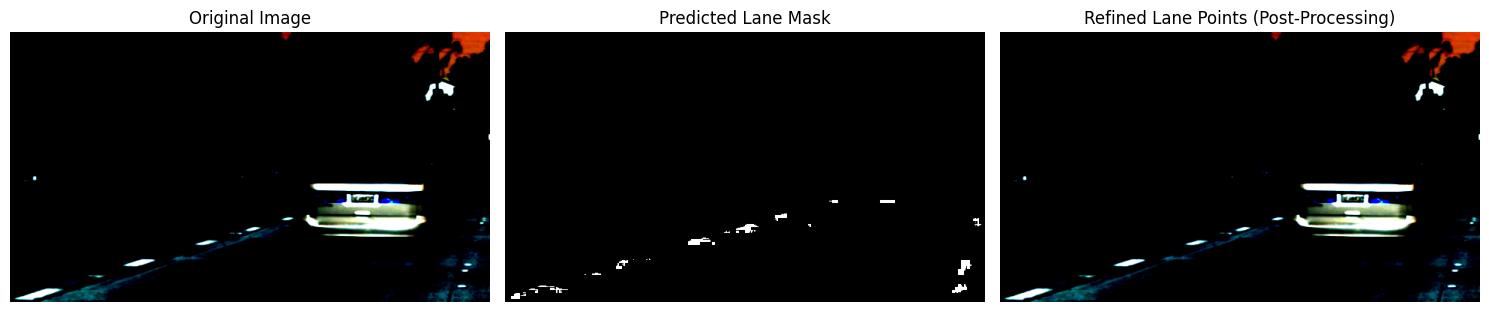

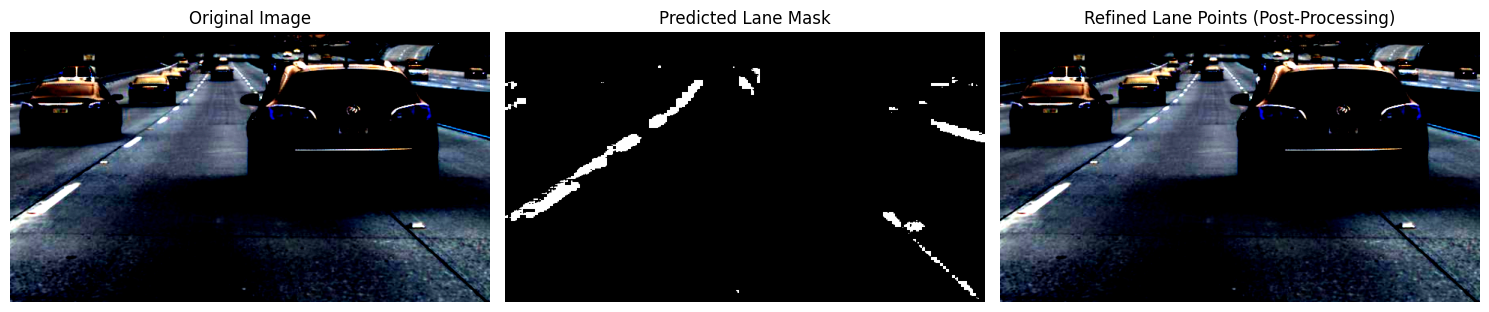

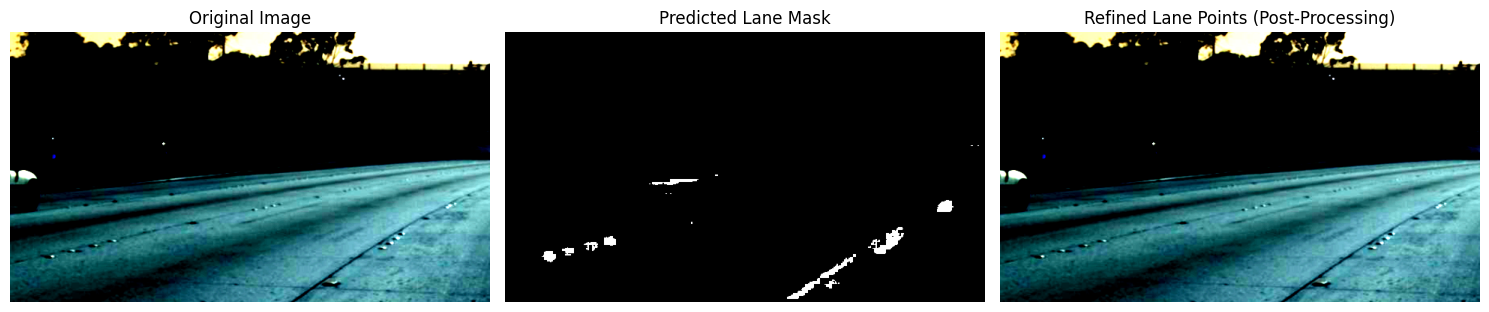

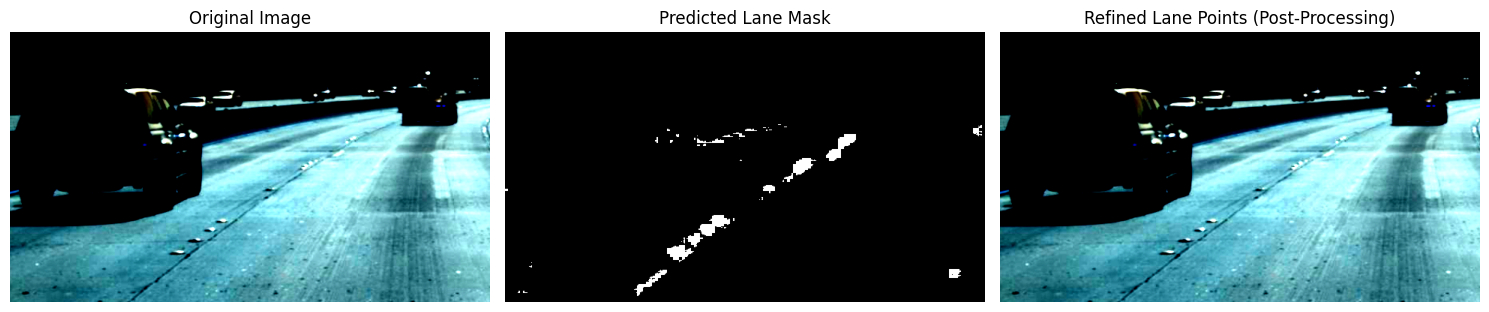

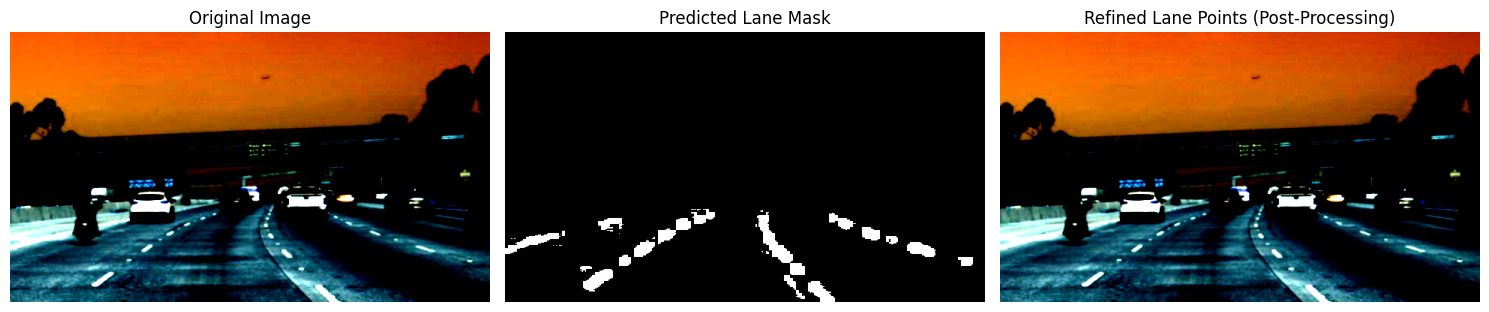

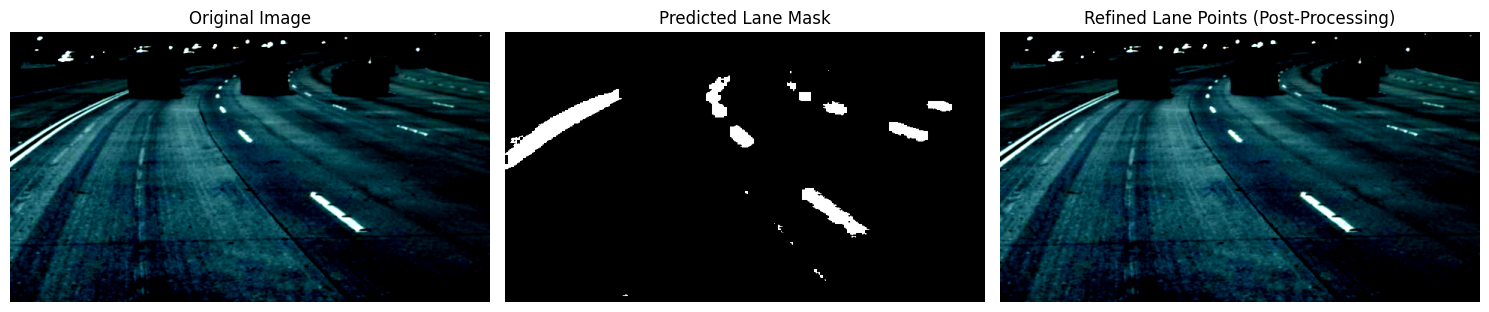

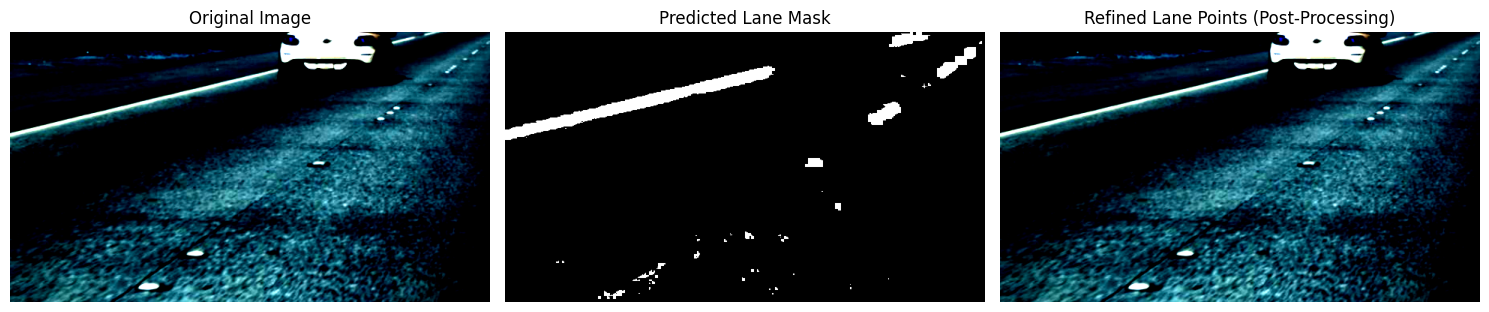

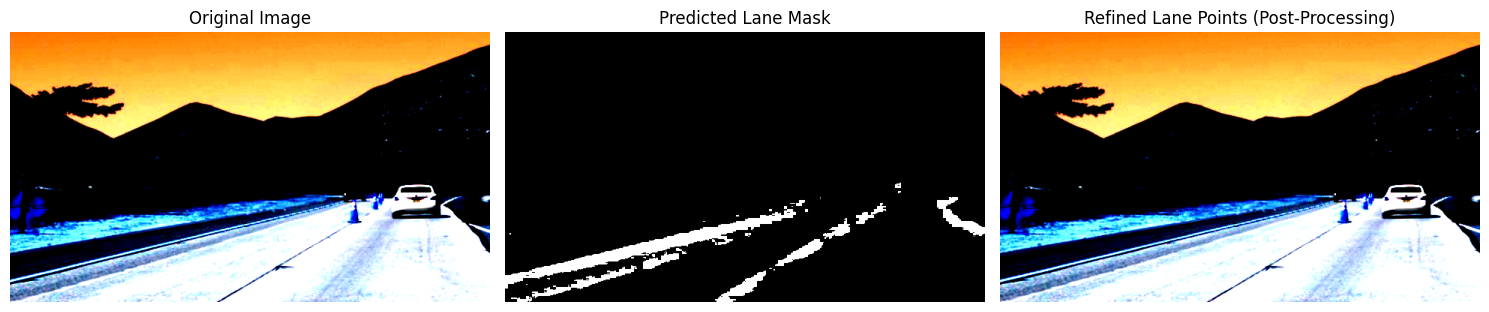

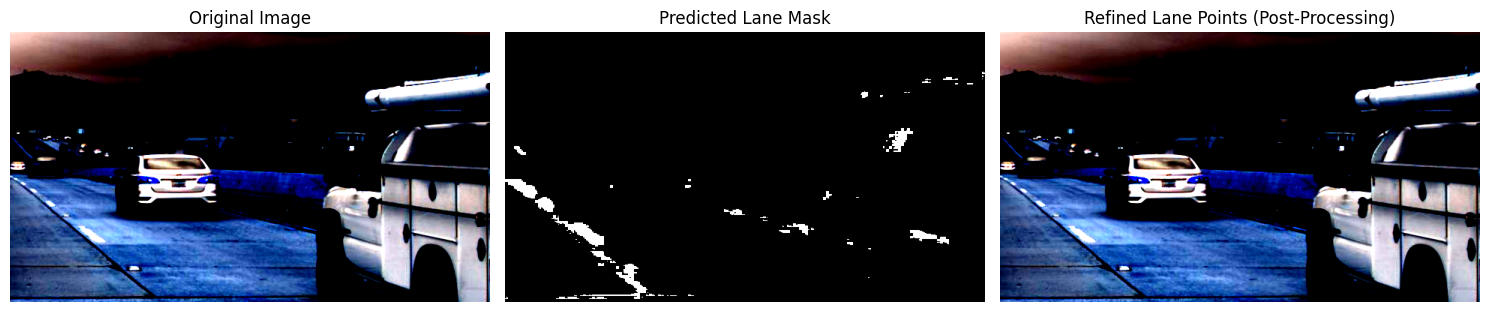

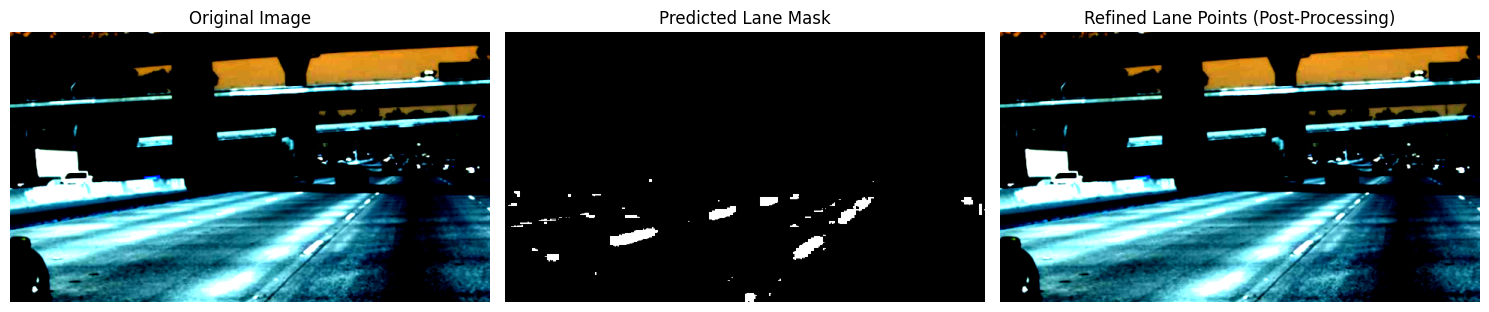

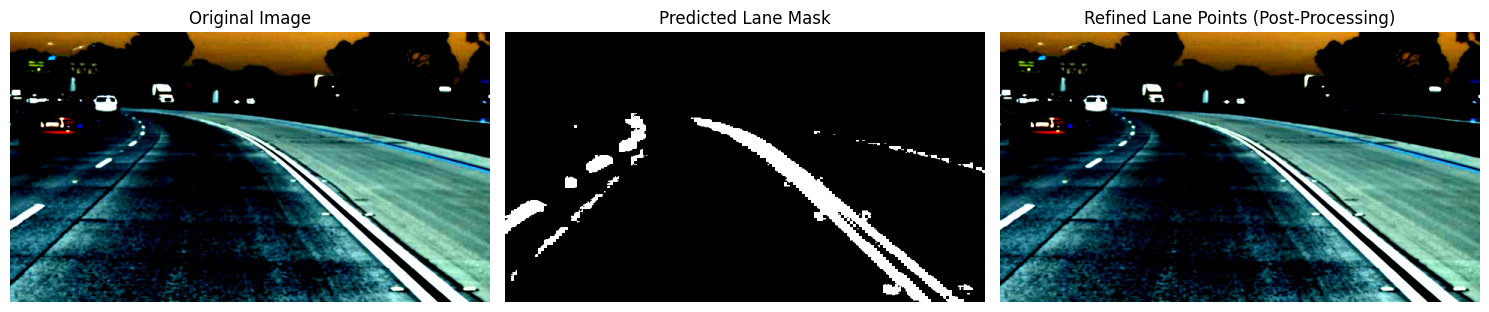

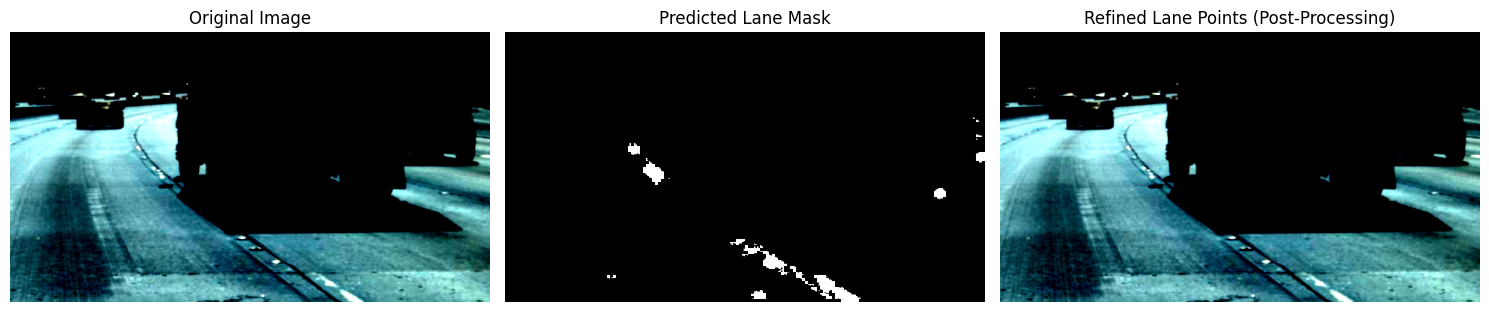

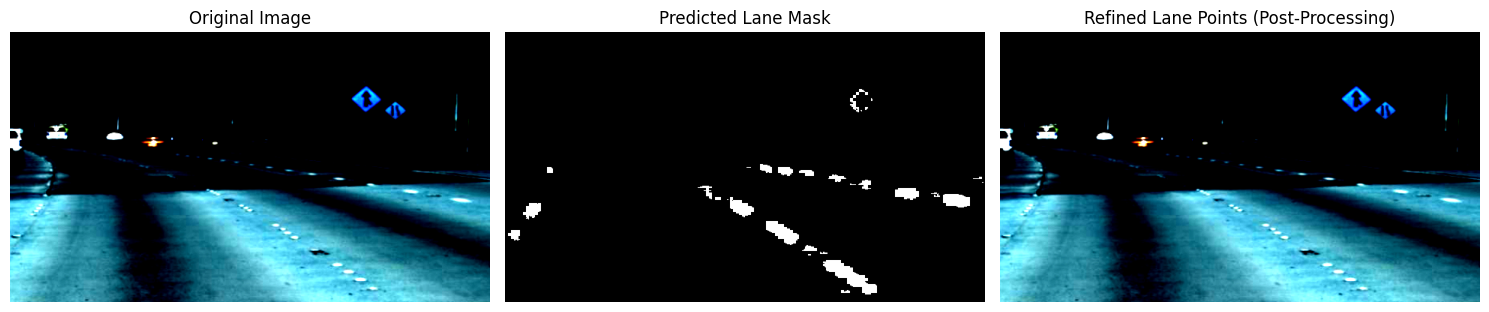

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_post_processing(frames, pred_mask, lane_points, idx=0):
    """
    Visualize the post-processed lane points overlaid on the original frame.

    Parameters:
        frames (tensor): The batch of input frames from the validation set.
        pred_mask (np.array): The binary mask predicted by the model.
        lane_points (list): List of lane points after post-processing.
        idx (int): Index to select a specific frame in the batch (default is 0).
    """
    # Extract the original frame (image) for visualization
    frame = frames[idx].cpu().numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    frame = np.clip(frame, 0, 1)  # Ensure values are within the valid range for RGB images

    # If the frame is grayscale (single channel), remove the channel dimension
    if frame.shape[-1] == 1:
        frame = frame.squeeze(axis=-1)

    # Create a new figure for visualization
    plt.figure(figsize=(15, 5))

    # Plot the original frame
    plt.subplot(1, 3, 1)
    plt.imshow(frame)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the predicted mask
    plt.subplot(1, 3, 2)
    pred_mask = pred_mask.squeeze()  # Remove batch/channel dimensions, if any
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Lane Mask")
    plt.axis('off')

    # Plot the refined lane points
    plt.subplot(1, 3, 3)
    plt.imshow(frame)  # Plot the original frame again as the background
    for lane in lane_points:
        # Plot the lane points (smoothed curves) on the image
        lane = np.array(lane)
        plt.plot(lane[:, 0], lane[:, 1], marker='o', markersize=2, label="Lane")

    plt.title("Refined Lane Points (Post-Processing)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming val_loader is available and model is loaded and processed
with torch.no_grad():
    for frames, masks in val_loader:
        frames = frames.to(device)
        outputs = model(frames)

        # Apply sigmoid and threshold to get binary mask
        preds = torch.sigmoid(outputs) > 0.5

        # Process the first prediction in the batch
        pred_mask = preds[0].cpu().numpy().astype(np.uint8)  # Convert to 2D binary mask
        lane_points = preprocess_predictions(pred_mask)

        # Visualize the post-processed results
        visualize_post_processing(frames, pred_mask, lane_points, idx=0)


#3D lane reconstruction